In [1]:
# Argparse
import argparse
opt = argparse.Namespace( # Fake parsed arguments
    seed=7,
    device=-1,
    cuda=False,
    visdom=True
)

# Util
import cdae.util as util
util.init(opt)

# Distributions
import cdae.distributions as dists

# Torch
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data
import torch.optim as optim

# Plotting
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.available
plt.style.use('seaborn-whitegrid')

%matplotlib notebook

# Stats
import scipy.stats

# Generative Model

The true generative model $p$ over latents $k, x$ and observed variables $y$ is:
\begin{align}
    k &\sim \mathrm{Categorical}([10, 20], [0.5, 0.5]) \\\
    x &\sim \mathrm{Normal}(0, 1) \\\
    y &\sim \mathrm{Normal}(f(k, x) ,1)
\end{align}
where $f: \mathbb R^2 \to \mathbb R$ is defined as
\begin{align}
    f(k, x) = a(k + x)^2 + b(k + x) + c.
\end{align}


<IPython.core.display.Javascript object>


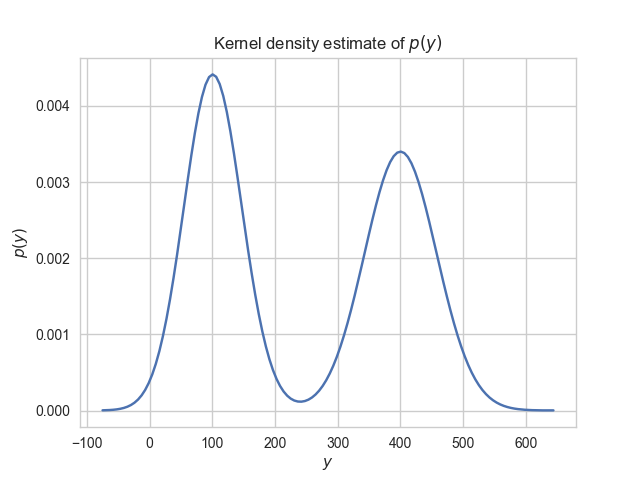

In [2]:
def f(k, x, a, b, c):
    return a * (k + x)**2 + b * (k + x) + c

def generative_model(a, b, c):
    k = np.random.choice([10, 20], p=[0.5, 0.5])
    x = np.random.normal(loc=0, scale=1)
    y = np.random.normal(f(k, x, a, b, c), 1)
    
    return k, x, y

(a, b, c) = (1, 0, 0)
num_data = 1000
data = np.array([generative_model(a, b, c)[2] for i in range(num_data)])
fig, ax = plt.subplots()
sns.kdeplot(data, ax=ax)
ax.set_title('Kernel density estimate of $p(y)$')
ax.set_xlabel('$y$')
ax.set_ylabel('$p(y)$')

# Generative Network

Assume that we actually don't know the form of $f$ and that we want to learn it, i.e. the true model $p$ from a dataset $(y^{(n)})_{n = 1}^N$.
Let's model the family of functions $f$ under consideration as a neural network parameterized by generative weights $\theta$ such that it maps from $\mathbb R^2$ to $\mathbb R$:

In [3]:
class GenerativeNetwork(nn.Module):
    def __init__(self):
        '''
        Initialize generative network.
        '''
        super(GenerativeNetwork, self).__init__()
        self.lin1 = nn.Linear(2, 16)
        self.lin2 = nn.Linear(16, 1)
        
        init.xavier_uniform(self.lin1.weight, gain=init.calculate_gain('relu'))
        init.xavier_uniform(self.lin2.weight)
        
    def f_approx(self, k, x):
        '''
        Returns output of current approximation of f.
        
        input:
            k: Variable [batch_size, 1]
            x: Variable [batch_size, 1]

        output: Variable [batch_size, 1]
        '''
        
        ret = self.lin1(torch.cat([k, x], dim=1))
        ret = F.relu(ret)
        ret = self.lin2(ret)
        
        return ret

    def forward(self, k, x, y):
        '''
        Returns log p_{\theta}(k, x, y)
        
        input:
            k: Variable [batch_size, 1]
            x: Variable [batch_size, 1]
            y: Variable [batch_size, 1]
            
        output: Variable [batch_size, 1]
        '''
        
        batch_size = k.size(0)
        
        logpdf_k = dists.categorical_logpdf(
            k, 
            categories=Variable(torch.Tensor([10, 20]).unsqueeze(-1).unsqueeze(-1).expand(2, batch_size, 1)),
            probabilities=Variable(torch.Tensor([0.5, 0.5]).unsqueeze(-1).unsqueeze(-1).expand(2, batch_size, 1))
        )
        
        logpdf_x = dists.normal_logpdf(x, Variable(torch.zeros(x.size())), Variable(torch.ones(x.size())))

        mean = self.f_approx(k, x)
        var = Variable(torch.ones(mean.size()))
        logpdf_y = dists.normal_logpdf(y, mean, var)
        
        return logpdf_k + logpdf_x + logpdf_y
    
    def sample(self, batch_size):
        '''
        Returns sample from the generative model.
        
        input:
            batch_size: int
        
        output:
            k: Tensor [batch_size, 1]
            x: Tensor [batch_size, 1]
            y: Tensor [batch_size, 1]
        '''
        
        k = dists.categorical_sample(
            categories=torch.Tensor([10, 20]).unsqueeze(-1).unsqueeze(-1).expand(2, batch_size, 1),
            probabilities=torch.Tensor([0.5, 0.5]).unsqueeze(-1).unsqueeze(-1).expand(2, batch_size, 1)
        )
        x = dists.normal_sample(
            mean=torch.zeros(batch_size, 1),
            var=torch.ones(batch_size, 1)
        )
        
        mean = self.f_approx(Variable(k, volatile=True), Variable(x, volatile=True)).data
        var = torch.ones(mean.size())
        y = dists.normal_sample(
            mean=mean,
            var=var
        )
        
        return k, x, y
    
    def plot_y_density(self, num_data, ax=None, **kwargs):
        '''
        Returns an Axes object with the kernel density estimate (KDE) of p_{\theta}(y).
        
        input:
            num_data: int. number of data points to make the KDE plot
            ax: (optional) Axes object
            
        output: update ax.
        '''
        
        if ax is None:
            _, ax = plt.subplots()

        _, _, data = self.sample(num_data)
        data = data.view(-1).numpy()

        sns.kdeplot(data, ax=ax, **kwargs)
        ax.set_title('Kernel density estimate of $p_{\\theta}(y)$')
        ax.set_xlabel('$y$')
        ax.set_ylabel('$p_{\\theta}(y)$')
        
        return ax

<IPython.core.display.Javascript object>


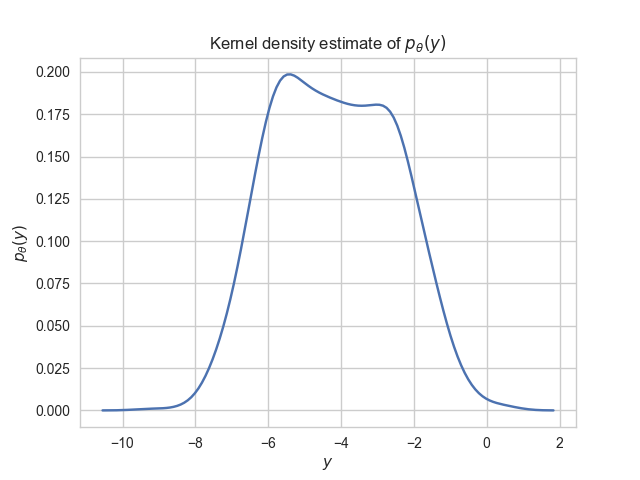

In [4]:
generative_network = GenerativeNetwork()
num_data = 1000
generative_network.plot_y_density(num_data)

# Inference Network

We seek to learn an inference network $q_{\phi}(k, x \lvert y)$ parameterized by $\phi$ which, given $y$ maps to the parameters of the distribution over $(k, x)$, ideally close to the posterior under the true model, $p(k, x \lvert y)$.

Let
\begin{align}
    q_{\phi}(k, x \lvert y) &= q_{\phi}(k \lvert y) q_{\phi}(x \lvert k, y) \\\
    q_{\phi}(k \lvert y) &= \mathrm{Categorical}([10, 20], [\phi_1, \phi_2]) \\\
    q_{\phi}(x \lvert k, y) &= \mathrm{Normal}(\phi_3, \phi_4)
\end{align}
where $\phi = [\phi_1, \dotsc, \phi_4]$ is the output of the inference network.

In [5]:
class InferenceNetwork(nn.Module):
    def __init__(self):
        '''
        Initialize inference network.
        '''
        
        super(InferenceNetwork, self).__init__()
        self.k_lin1 = nn.Linear(1, 16)
        self.k_lin2 = nn.Linear(16, 2)
        
        self.x_mean_lin1 = nn.Linear(2, 16)
        self.x_mean_lin2 = nn.Linear(16, 1)
        
        self.x_var_lin1 = nn.Linear(2, 16)
        self.x_var_lin2 = nn.Linear(16, 1)

        init.xavier_uniform(self.k_lin1.weight, gain=init.calculate_gain('relu'))
        init.xavier_uniform(self.k_lin2.weight)
        init.xavier_uniform(self.x_mean_lin1.weight, gain=init.calculate_gain('relu'))
        init.xavier_uniform(self.x_mean_lin2.weight)
        init.xavier_uniform(self.x_var_lin1.weight, gain=init.calculate_gain('relu'))
        init.xavier_uniform(self.x_var_lin2.weight)
        
    def get_q_k_params(self, y):
        '''
        Returns parameters \phi_1, \phi_2.
        
        input:
            y: Variable [batch_size, 1]
            
        output: Variable [batch_size, 2]
        '''
        
        ret = self.k_lin1(y)
        ret = F.relu(ret)
        ret = self.k_lin2(ret)
        ret = F.softmax(ret)
        
        return ret
    
    def get_q_x_params(self, k, y):
        '''
        Returns parameters \phi_3, \phi_4.
        
        input:
            k: Variable [batch_size, 1]
            y: Variable [batch_size, 1]
            
        output:
            mean: Variable [batch_size, 1]
            var: Variable [batch_size, 1]
        '''
        
        mean = self.x_mean_lin1(torch.cat([k, y], dim=1))
        mean = F.relu(mean)
        mean = self.x_mean_lin2(mean)
        
        var = self.x_var_lin1(torch.cat([k, y], dim=1))
        var = F.relu(var)
        var = self.x_var_lin2(var)
        var = F.softplus(var)
        
        return mean, var
        
    def forward(self, k, x, y):
        '''
        Returns log q_{\phi}(k, x | y)
        
        input:
            k: Variable [batch_size, 1]
            x: Variable [batch_size, 1]
            y: Variable [batch_size, 1]
            
        output: Variable [batch_size, 1]
        '''
        batch_size, _ = k.size()
        
        probabilities = self.get_q_k_params(y)
        logpdf_k = dists.categorical_logpdf(
            k,
            categories=Variable(torch.Tensor([10, 20]).unsqueeze(-1).unsqueeze(-1).expand(2, batch_size, 1)),
            probabilities=torch.t(probabilities).unsqueeze(-1)
        )
        
        mean, var = self.get_q_x_params(k, y)
        logpdf_x = dists.normal_logpdf(
            x,
            mean=mean,
            var=var
        )
        
        return logpdf_k + logpdf_x
    
    def sample(self, y):
        '''
        Returns samples from q_{\phi}(k, x | y)
        
        input:
            y: Tensor [batch_size, 1]

        output:
            k: Tensor [batch_size, 1]
            x: Tensor [batch_size, 1]
        '''
        
        batch_size = y.size(0)
        
        probabilities = self.get_q_k_params(Variable(y, volatile=True)).data
        k = dists.categorical_sample(
            categories=torch.Tensor([10, 20]).unsqueeze(-1).unsqueeze(-1).expand(2, batch_size, 1),
            probabilities=torch.t(probabilities).unsqueeze(-1)
        )
        
        mean, var = self.get_q_x_params(Variable(k, volatile=True), Variable(y, volatile=True))
        x = dists.normal_sample(
            mean=mean.data,
            var=var.data
        )
        
        return k, x

average_q_logpdf
-4.458398342132568
y
405.4825609905431


<IPython.core.display.Javascript object>


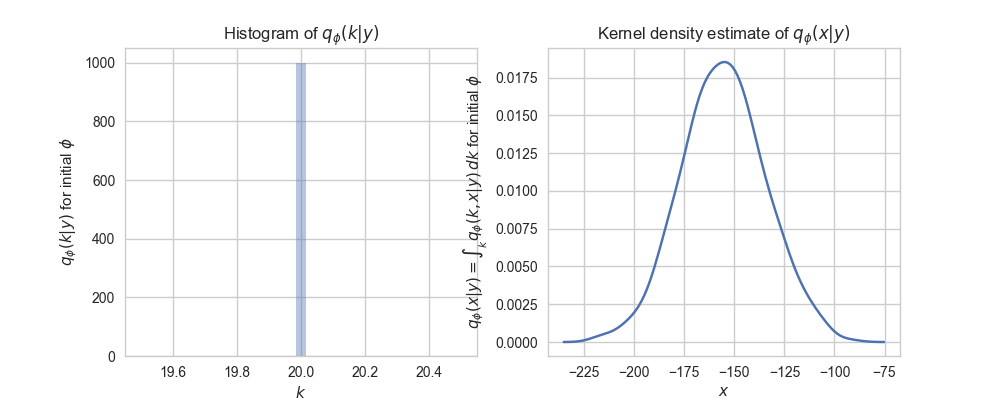

In [6]:
inference_network = InferenceNetwork()
(a, b, c) = (1, 0, 0)
y_single = generative_model(a, b, c)[2]
y = torch.Tensor([[y_single]]).expand(1000, 1)
k, x = inference_network.sample(y)
average_q_logpdf = torch.mean(
    inference_network.forward(
        Variable(k, volatile=True),
        Variable(x, volatile=True), 
        Variable(y, volatile=True)
    )
)
print('average_q_logpdf')
print(average_q_logpdf.data[0])

print('y')
print(y_single)

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(10, 4)

sns.distplot(k.view(-1).numpy(), ax=ax[0], kde=False)
ax[0].set_title('Histogram of $q_{\phi}(k | y)$')
ax[0].set_xlabel('$k$')
ax[0].set_ylabel('$q_{\phi}(k | y)$ for initial $\phi$')

sns.kdeplot(x.view(-1).numpy(), ax=ax[1])
ax[1].set_title('Kernel density estimate of $q_{\phi}(x | y)$')
ax[1].set_xlabel('$x$')
ax[1].set_ylabel('$q_{\phi}(x | y) = \int_k q_{\phi}(k, x | y) \,dk$ for initial $\phi$')

# Training Loop

In [7]:
class SimpleDataset(torch.utils.data.Dataset):
    def __init__(self, infinite_data=None, num_data=None, data_generator=None):
        '''
        Initializes SimpleDataset. If infinite_data is True, generates data on the fly,
        otherwise generates data once at the start.
        
        input:
            infinite_data: bool. If True, supply fake_num_data and data_generator, otherwise supply data
            num_data: number. In the case of infinite_data, this forms as a fake num_data in order to be able to talk about "epochs".
            data_generator: function that generates a sample from the true generative model
        '''
        assert(type(infinite_data) is bool)
        assert(type(num_data) is int)
        assert(callable(data_generator))
        
        self.infinite_data = infinite_data
        if infinite_data:
            self.num_data = num_data
            self.data_generator = lambda: np.float32(data_generator())
        else:
            self.num_data = num_data
            self.data = np.array([np.float32(generative_model(a, b, c)[2]) for i in range(num_data)])
    
    def __len__(self):
        return self.num_data
    
    def __getitem__(self, index):
        if self.infinite_data:
            return self.data_generator()
        else:
            return self.data[index]

In [8]:
inference_network = InferenceNetwork()
generative_network = GenerativeNetwork()

inference_network_optim = optim.Adam(inference_network.parameters())
generative_network_optim = optim.Adam(generative_network.parameters())

num_iterations = 10
batch_size = 50
num_data = 100
generative_epochs_per_iteration = 100
inference_epochs_per_iteration = 10
num_generative_epochs = np.repeat(generative_epochs_per_iteration, num_iterations)
num_inference_epochs = np.repeat(inference_epochs_per_iteration, num_iterations)

(a, b, c) = (1, 0, 0)
data_generator = lambda: generative_model(a, b, c)[2]
simple_dataset = SimpleDataset(infinite_data=False, num_data=num_data, data_generator=data_generator)
simple_dataloader = torch.utils.data.DataLoader(simple_dataset, batch_size=batch_size, shuffle=True)

generative_network_objective = []
inference_network_objective = []
if opt.visdom:
    util.vis.close()
    generative_network_objective_line = util.vis.line(
        X=np.array([0]), 
        Y=np.array([0]),
        opts=dict(
            xlabel='Epoch',
            ylabel='Objective (to maximize)',
            title='Generative network objective'
        )
    )
    
    inference_network_objective_line = util.vis.line(
        X=np.array([0]), 
        Y=np.array([0]),
        opts=dict(
            xlabel='Epoch',
            ylabel='Objective (to minimize)',
            title='Inference network objective'
        )
    )

for i in range(num_iterations):
    util.logger.info('Iteration {}'.format(i))
    
    # Step 1
    for epoch in range(num_generative_epochs[i]):
        util.logger.info('Generative network step | Epoch {}'.format(epoch))
        temp_generative_network_objective = []
        for _, y in enumerate(simple_dataloader):
            k, x = inference_network.sample(y.unsqueeze(1))
            
            generative_network_optim.zero_grad()
            logpdf_generative_network = generative_network.forward(Variable(k), Variable(x), Variable(y))
            temp_generative_network_objective += logpdf_generative_network.data.numpy().tolist()
            utility = torch.mean(logpdf_generative_network)
            loss = -utility # we want to maximize
            loss.backward()
            generative_network_optim.step()
        generative_network_objective.append(np.mean(temp_generative_network_objective))
        
        util.vis.line(
            X=np.arange(len(generative_network_objective)),
            Y=np.nan_to_num(np.array(generative_network_objective)),
            update='replace',
            win=generative_network_objective_line
        )
    
    # Step 2
    for epoch in range(num_inference_epochs[i]):
        util.logger.info('Inference network step | Epoch {}'.format(epoch))
        temp_inference_network_objective = []
        for batch_size in util.chunk(num_data, batch_size):
            k, x, y = generative_network.sample(batch_size)
            
            inference_network_optim.zero_grad()
            logpdf_inference_network = inference_network.forward(Variable(k), Variable(x), Variable(y))
            temp_inference_network_objective += logpdf_inference_network.data.numpy().tolist()
            loss = torch.mean(logpdf_inference_network)
            loss.backward()
            inference_network_optim.step()
        inference_network_objective.append(np.mean(temp_inference_network_objective))
        util.vis.line(
            X=np.arange(len(inference_network_objective)),
            Y=np.nan_to_num(np.array(inference_network_objective)),
            update='replace',
            win=inference_network_objective_line
        )

2017-07-20 19:21:37,509: Iteration 0
2017-07-20 19:21:37,510: Generative network step | Epoch 0
2017-07-20 19:21:37,521: Generative network step | Epoch 1
2017-07-20 19:21:37,533: Generative network step | Epoch 2
2017-07-20 19:21:37,544: Generative network step | Epoch 3
2017-07-20 19:21:37,555: Generative network step | Epoch 4
2017-07-20 19:21:37,567: Generative network step | Epoch 5
2017-07-20 19:21:37,578: Generative network step | Epoch 6
2017-07-20 19:21:37,588: Generative network step | Epoch 7
2017-07-20 19:21:37,600: Generative network step | Epoch 8
2017-07-20 19:21:37,610: Generative network step | Epoch 9
2017-07-20 19:21:37,621: Generative network step | Epoch 10
2017-07-20 19:21:37,632: Generative network step | Epoch 11
2017-07-20 19:21:37,643: Generative network step | Epoch 12
2017-07-20 19:21:37,654: Generative network step | Epoch 13
2017-07-20 19:21:37,665: Generative network step | Epoch 14
2017-07-20 19:21:37,676: Generative network step | Epoch 15
2017-07-20 19

2017-07-20 19:21:39,037: Generative network step | Epoch 26
2017-07-20 19:21:39,047: Generative network step | Epoch 27
2017-07-20 19:21:39,058: Generative network step | Epoch 28
2017-07-20 19:21:39,070: Generative network step | Epoch 29
2017-07-20 19:21:39,080: Generative network step | Epoch 30
2017-07-20 19:21:39,091: Generative network step | Epoch 31
2017-07-20 19:21:39,101: Generative network step | Epoch 32
2017-07-20 19:21:39,112: Generative network step | Epoch 33
2017-07-20 19:21:39,123: Generative network step | Epoch 34
2017-07-20 19:21:39,133: Generative network step | Epoch 35
2017-07-20 19:21:39,144: Generative network step | Epoch 36
2017-07-20 19:21:39,155: Generative network step | Epoch 37
2017-07-20 19:21:39,167: Generative network step | Epoch 38
2017-07-20 19:21:39,178: Generative network step | Epoch 39
2017-07-20 19:21:39,190: Generative network step | Epoch 40
2017-07-20 19:21:39,201: Generative network step | Epoch 41
2017-07-20 19:21:39,213: Generative netw

2017-07-20 19:21:40,635: Generative network step | Epoch 53
2017-07-20 19:21:40,645: Generative network step | Epoch 54
2017-07-20 19:21:40,658: Generative network step | Epoch 55
2017-07-20 19:21:40,668: Generative network step | Epoch 56
2017-07-20 19:21:40,681: Generative network step | Epoch 57
2017-07-20 19:21:40,691: Generative network step | Epoch 58
2017-07-20 19:21:40,703: Generative network step | Epoch 59
2017-07-20 19:21:40,716: Generative network step | Epoch 60
2017-07-20 19:21:40,729: Generative network step | Epoch 61
2017-07-20 19:21:40,739: Generative network step | Epoch 62
2017-07-20 19:21:40,750: Generative network step | Epoch 63
2017-07-20 19:21:40,762: Generative network step | Epoch 64
2017-07-20 19:21:40,774: Generative network step | Epoch 65
2017-07-20 19:21:40,786: Generative network step | Epoch 66
2017-07-20 19:21:40,798: Generative network step | Epoch 67
2017-07-20 19:21:40,810: Generative network step | Epoch 68
2017-07-20 19:21:40,821: Generative netw

2017-07-20 19:21:42,285: Generative network step | Epoch 80
2017-07-20 19:21:42,296: Generative network step | Epoch 81
2017-07-20 19:21:42,308: Generative network step | Epoch 82
2017-07-20 19:21:42,319: Generative network step | Epoch 83
2017-07-20 19:21:42,332: Generative network step | Epoch 84
2017-07-20 19:21:42,343: Generative network step | Epoch 85
2017-07-20 19:21:42,356: Generative network step | Epoch 86
2017-07-20 19:21:42,367: Generative network step | Epoch 87
2017-07-20 19:21:42,379: Generative network step | Epoch 88
2017-07-20 19:21:42,390: Generative network step | Epoch 89
2017-07-20 19:21:42,402: Generative network step | Epoch 90
2017-07-20 19:21:42,415: Generative network step | Epoch 91
2017-07-20 19:21:42,426: Generative network step | Epoch 92
2017-07-20 19:21:42,437: Generative network step | Epoch 93
2017-07-20 19:21:42,450: Generative network step | Epoch 94
2017-07-20 19:21:42,463: Generative network step | Epoch 95
2017-07-20 19:21:42,474: Generative netw

2017-07-20 19:21:43,930: Inference network step | Epoch 7
2017-07-20 19:21:43,941: Inference network step | Epoch 8
2017-07-20 19:21:43,952: Inference network step | Epoch 9
2017-07-20 19:21:43,964: Iteration 5
2017-07-20 19:21:43,965: Generative network step | Epoch 0
2017-07-20 19:21:43,977: Generative network step | Epoch 1
2017-07-20 19:21:43,988: Generative network step | Epoch 2
2017-07-20 19:21:44,001: Generative network step | Epoch 3
2017-07-20 19:21:44,014: Generative network step | Epoch 4
2017-07-20 19:21:44,025: Generative network step | Epoch 5
2017-07-20 19:21:44,037: Generative network step | Epoch 6
2017-07-20 19:21:44,050: Generative network step | Epoch 7
2017-07-20 19:21:44,062: Generative network step | Epoch 8
2017-07-20 19:21:44,074: Generative network step | Epoch 9
2017-07-20 19:21:44,086: Generative network step | Epoch 10
2017-07-20 19:21:44,100: Generative network step | Epoch 11
2017-07-20 19:21:44,112: Generative network step | Epoch 12
2017-07-20 19:21:44

2017-07-20 19:21:45,629: Generative network step | Epoch 24
2017-07-20 19:21:45,640: Generative network step | Epoch 25
2017-07-20 19:21:45,653: Generative network step | Epoch 26
2017-07-20 19:21:45,666: Generative network step | Epoch 27
2017-07-20 19:21:45,679: Generative network step | Epoch 28
2017-07-20 19:21:45,691: Generative network step | Epoch 29
2017-07-20 19:21:45,703: Generative network step | Epoch 30
2017-07-20 19:21:45,716: Generative network step | Epoch 31
2017-07-20 19:21:45,728: Generative network step | Epoch 32
2017-07-20 19:21:45,741: Generative network step | Epoch 33
2017-07-20 19:21:45,753: Generative network step | Epoch 34
2017-07-20 19:21:45,767: Generative network step | Epoch 35
2017-07-20 19:21:45,779: Generative network step | Epoch 36
2017-07-20 19:21:45,791: Generative network step | Epoch 37
2017-07-20 19:21:45,804: Generative network step | Epoch 38
2017-07-20 19:21:45,817: Generative network step | Epoch 39
2017-07-20 19:21:45,829: Generative netw

2017-07-20 19:21:47,348: Generative network step | Epoch 51
2017-07-20 19:21:47,361: Generative network step | Epoch 52
2017-07-20 19:21:47,373: Generative network step | Epoch 53
2017-07-20 19:21:47,386: Generative network step | Epoch 54
2017-07-20 19:21:47,398: Generative network step | Epoch 55
2017-07-20 19:21:47,410: Generative network step | Epoch 56
2017-07-20 19:21:47,423: Generative network step | Epoch 57
2017-07-20 19:21:47,435: Generative network step | Epoch 58
2017-07-20 19:21:47,448: Generative network step | Epoch 59
2017-07-20 19:21:47,460: Generative network step | Epoch 60
2017-07-20 19:21:47,473: Generative network step | Epoch 61
2017-07-20 19:21:47,486: Generative network step | Epoch 62
2017-07-20 19:21:47,499: Generative network step | Epoch 63
2017-07-20 19:21:47,511: Generative network step | Epoch 64
2017-07-20 19:21:47,524: Generative network step | Epoch 65
2017-07-20 19:21:47,537: Generative network step | Epoch 66
2017-07-20 19:21:47,549: Generative netw

2017-07-20 19:21:49,125: Generative network step | Epoch 78
2017-07-20 19:21:49,139: Generative network step | Epoch 79
2017-07-20 19:21:49,151: Generative network step | Epoch 80
2017-07-20 19:21:49,165: Generative network step | Epoch 81
2017-07-20 19:21:49,177: Generative network step | Epoch 82
2017-07-20 19:21:49,190: Generative network step | Epoch 83
2017-07-20 19:21:49,204: Generative network step | Epoch 84
2017-07-20 19:21:49,217: Generative network step | Epoch 85
2017-07-20 19:21:49,231: Generative network step | Epoch 86
2017-07-20 19:21:49,244: Generative network step | Epoch 87
2017-07-20 19:21:49,258: Generative network step | Epoch 88
2017-07-20 19:21:49,272: Generative network step | Epoch 89
2017-07-20 19:21:49,284: Generative network step | Epoch 90
2017-07-20 19:21:49,297: Generative network step | Epoch 91
2017-07-20 19:21:49,310: Generative network step | Epoch 92
2017-07-20 19:21:49,324: Generative network step | Epoch 93
2017-07-20 19:21:49,336: Generative netw

2017-07-20 19:21:50,915: Inference network step | Epoch 5
2017-07-20 19:21:50,927: Inference network step | Epoch 6
2017-07-20 19:21:50,938: Inference network step | Epoch 7
2017-07-20 19:21:50,950: Inference network step | Epoch 8
2017-07-20 19:21:50,961: Inference network step | Epoch 9


<IPython.core.display.Javascript object>


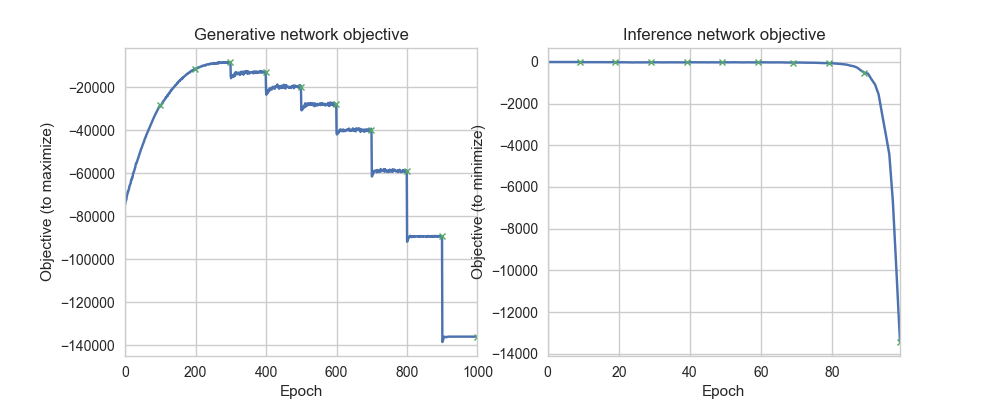

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(10, 4)
ax[0].plot(
    np.arange(len(generative_network_objective)),
    np.nan_to_num(generative_network_objective)
)
ax[0].plot(
    np.cumsum(num_generative_epochs) - 1,
    np.nan_to_num(np.array(generative_network_objective)[np.cumsum(num_generative_epochs) - 1]),
    linestyle='None',
    marker='x',
    markersize=5,
    markeredgewidth=1
)
ax[0].set_xlim([0, len(generative_network_objective) - 1])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Objective (to maximize)')
ax[0].set_title('Generative network objective')

ax[1].plot(
    np.arange(len(inference_network_objective)),
    np.nan_to_num(inference_network_objective)
)
ax[1].plot(
    np.cumsum(num_inference_epochs) - 1,
    np.nan_to_num(np.array(inference_network_objective)[np.cumsum(num_inference_epochs) - 1]),
    linestyle='None',
    marker='x',
    markersize=5,
    markeredgewidth=1
)
ax[1].set_xlim([0, len(inference_network_objective) - 1])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Objective (to minimize)')
ax[1].set_title('Inference network objective')

# Testing the Generative Model

<IPython.core.display.Javascript object>


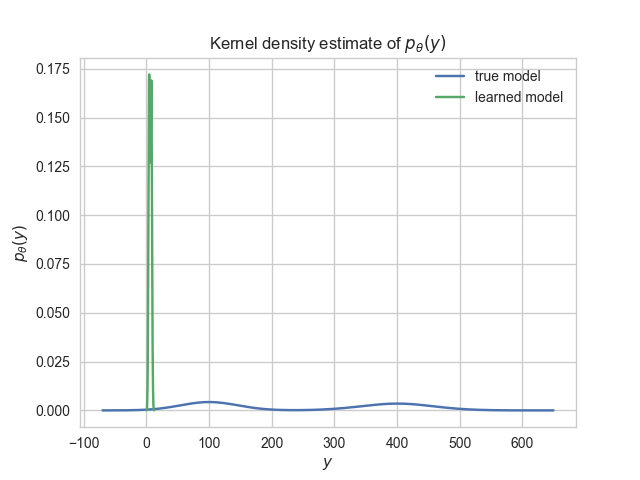

In [10]:
num_data = 1000
data = np.array([generative_model(a, b, c)[2] for i in range(num_data)])
fig, ax = plt.subplots()
sns.kdeplot(data, ax=ax, label='true model')
generative_network.plot_y_density(num_data, ax=ax, label='learned model')

# Testing Inference

In [11]:
(a, b, c) = (1, 0, 0)
y_test = generative_model(a, b, c)[2]
y_test

81.7360493046352

## Inference network output

<IPython.core.display.Javascript object>


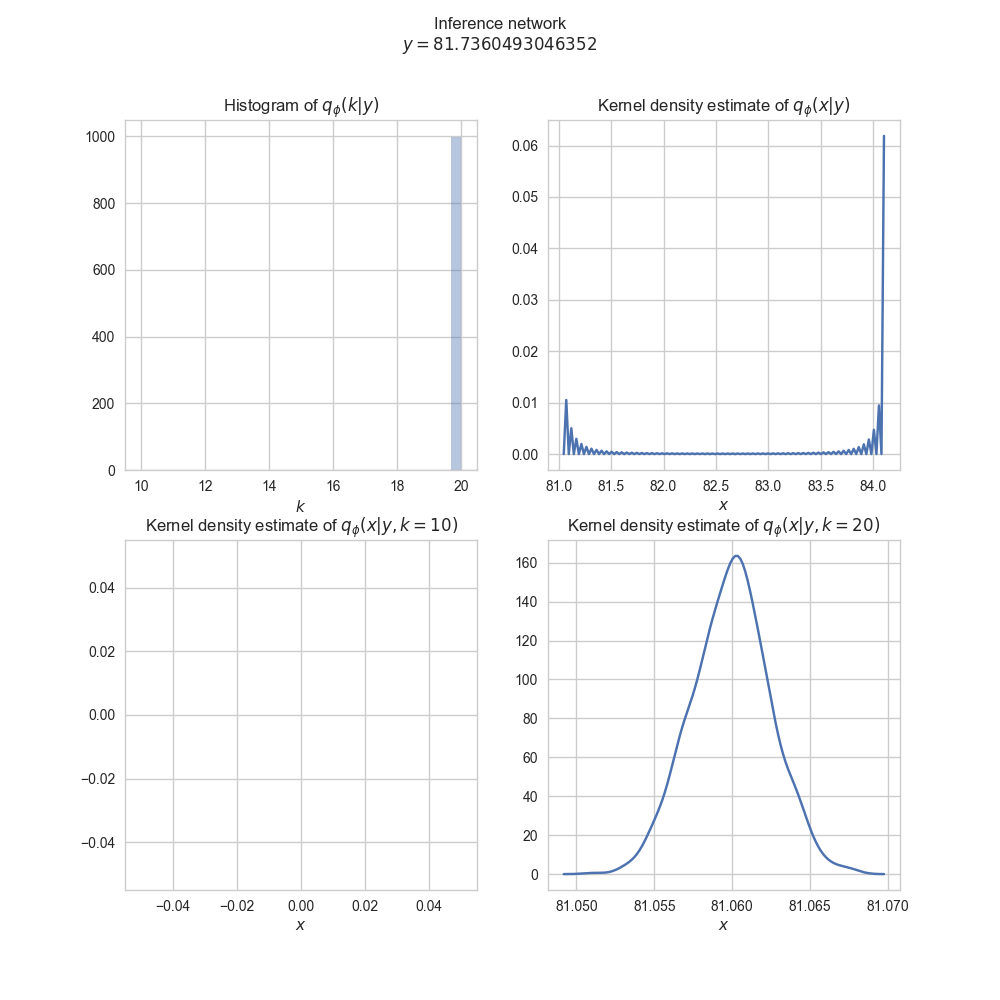

/Users/tuananhle/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/tuananhle/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [12]:
inference_network = InferenceNetwork()
y = torch.Tensor([[y_test]]).expand(1000, 1)
k, x = inference_network.sample(y)

fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10, 10)
fig.suptitle('Inference network\n$y = {}$'.format(y_test))

sns.distplot(k.view(-1).numpy(), ax=ax[0][0], kde=False)
ax[0][0].set_title('Histogram of $q_{\phi}(k | y)$')
ax[0][0].set_xlabel('$k$')

sns.kdeplot(x.view(-1).numpy(), ax=ax[0][1])
ax[0][1].set_title('Kernel density estimate of $q_{\phi}(x | y)$')
ax[0][1].set_xlabel('$x$')

ax[1][0].set_title('Kernel density estimate of $q_{\phi}(x | y, k = 10)$')
ax[1][0].set_xlabel('$x$')
if len(x[k == 10]) != 0:
    sns.kdeplot(x[k == 10].view(-1).numpy(), ax=ax[1][0])

ax[1][1].set_title('Kernel density estimate of $q_{\phi}(x | y, k = 20)$')
ax[1][1].set_xlabel('$x$')
if len(x[k == 20]) != 0:
    sns.kdeplot(x[k == 20].view(-1).numpy(), ax=ax[1][1])

## Importance sampling

<IPython.core.display.Javascript object>


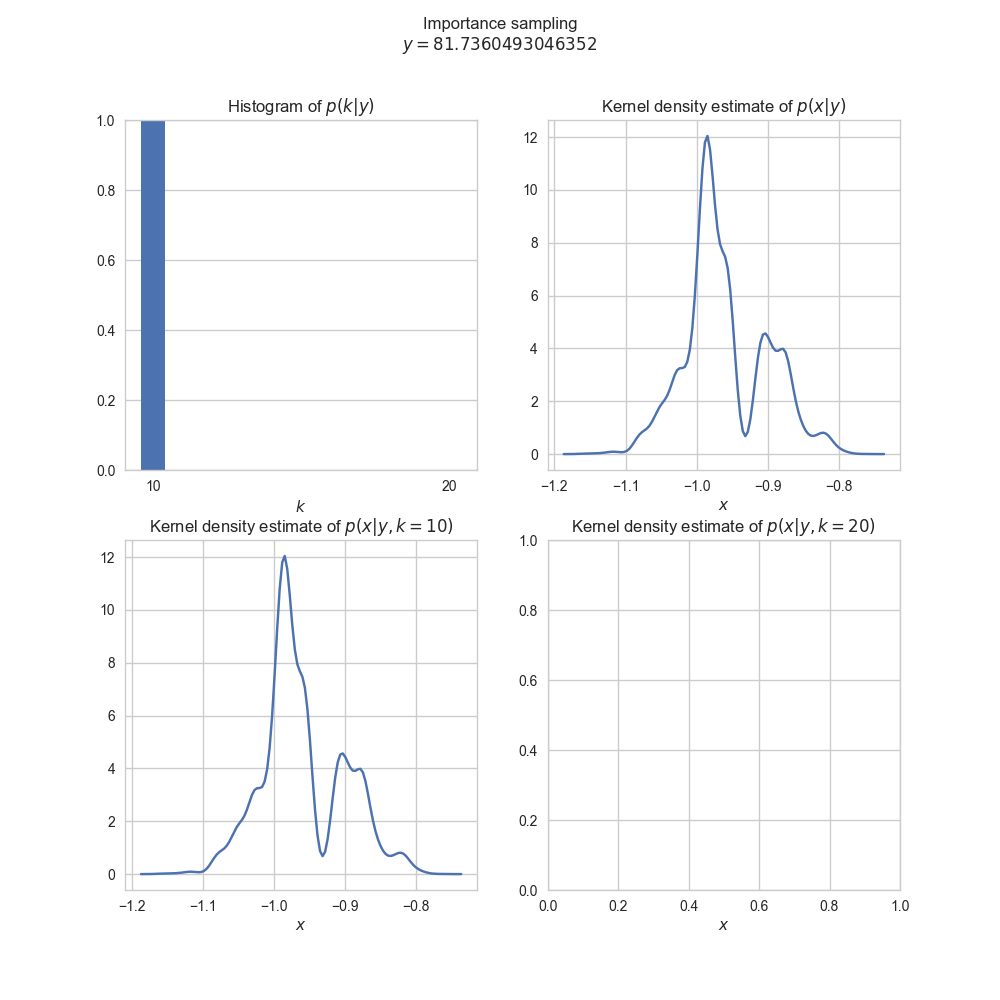

In [13]:
num_particles = 1000
num_posterior_samples = 10000

# Importance sampling
particles = []
for p in range(num_particles):
    k, x, _ = generative_model(a, b, c)
    weight = scipy.stats.norm.pdf(y_test, f(k, x, a, b, c), 1)
    particles.append(({'k': k, 'x': x}, weight))
    
# Resample particles
values, weights = zip(*particles)
normalized_weights = list(np.array(weights) / np.sum(np.array(weights)))
posterior_samples = [np.random.choice(values, p=normalized_weights) for _ in range(num_posterior_samples)]

# Plotting
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(10, 10)
fig.suptitle('Importance sampling\n$y = {}$'.format(y_test))

values = [10, 20]
normalized_weights = [
    sum(posterior_sample['k'] == 10 for posterior_sample in posterior_samples) / len(posterior_samples),
    sum(posterior_sample['k'] == 20 for posterior_sample in posterior_samples) / len(posterior_samples),
]
ax[0][0].bar(values, normalized_weights, tick_label=values)
ax[0][0].xaxis.grid(False)
ax[0][0].set_ylim([0, 1])
ax[0][0].set_title('Histogram of $p(k | y)$')
ax[0][0].set_xlabel('$k$')

sns.distplot([posterior_sample['x'] for posterior_sample in posterior_samples], hist=False, ax=ax[0][1])
ax[0][1].set_title('Kernel density estimate of $p(x | y)$')
ax[0][1].set_xlabel('$x$')

ax[1][0].set_title('Kernel density estimate of $p(x | y, k = 10)$')
ax[1][0].set_xlabel('$x$')
if normalized_weights[0] != 0:
    sns.distplot(
        [posterior_sample['x'] for posterior_sample in posterior_samples if posterior_sample['k'] == 10], 
        hist=False,
        ax=ax[1][0]
    )

ax[1][1].set_title('Kernel density estimate of $p(x | y, k = 20)$')
ax[1][1].set_xlabel('$x$')
if normalized_weights[1] != 0:
    sns.distplot(
        [posterior_sample['x'] for posterior_sample in posterior_samples if posterior_sample['k'] == 20], 
        hist=False,
        ax=ax[1][1]
    )